<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v7: Productionising Gradient capturing and visualisation
This notebook carries on from v4 with work to productionise the capture and display of gradient information.

However it takes a more cautious small-step approach:
* Uses a custom-training loop instead of trying to wrap an optimizer (later experience has shown that the optimizer wrapping needs some more work to be compatible with the later versions of Keras)
* Doesn't try to work out gradient sign changes, just the raw gradients.
* Supports some more variations of model architecture.
* Tries to be as close to plug'n'play as possible.

In [97]:
# Clone repo and load its modules

import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
!cd repo && git pull

import sys
sys.path.append('repo')

import toolkit
from importlib import reload
reload(toolkit)

HEAD is now at 9a79122 First version of plotter for gradient stats. Currently with only the all-model and layer-contributions plots.
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 4), reused 4 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (6/6), 1.27 KiB | 326.00 KiB/s, done.
From https://github.com/malcolmlett/ml-learning
   9a79122..c5aa76c  main       -> origin/main
Updating 9a79122..c5aa76c
Fast-forward
 toolkit.py | 57 ++++++++++++++++++++++++++++++++++++++++++---------------
 1 file changed, 42 insertions(+), 15 deletions(-)


<module 'toolkit' from '/content/repo/toolkit.py'>

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit

In [3]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

## Baseline

In [89]:
def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


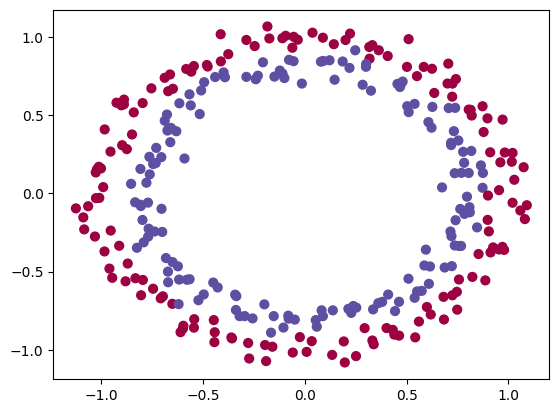

In [80]:
def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

Epoch    50 - 86.52ms/epoch: loss: 0.6558  
Epoch   100 - 42.18ms/epoch: loss: 0.2255  
Epoch   150 - 28.63ms/epoch: loss: 0.0388  
Epoch   200 - 28.30ms/epoch: loss: 0.0148  
Epoch   250 - 29.56ms/epoch: loss: 0.0075  
Epoch   300 - 26.70ms/epoch: loss: 0.0043  
Epoch   350 - 26.54ms/epoch: loss: 0.0027  
Epoch   400 - 27.72ms/epoch: loss: 0.0017  
Epoch   450 - 37.96ms/epoch: loss: 0.0012  
Epoch   500 - 44.62ms/epoch: loss: 0.0008  
Total training time: 18.93 secs


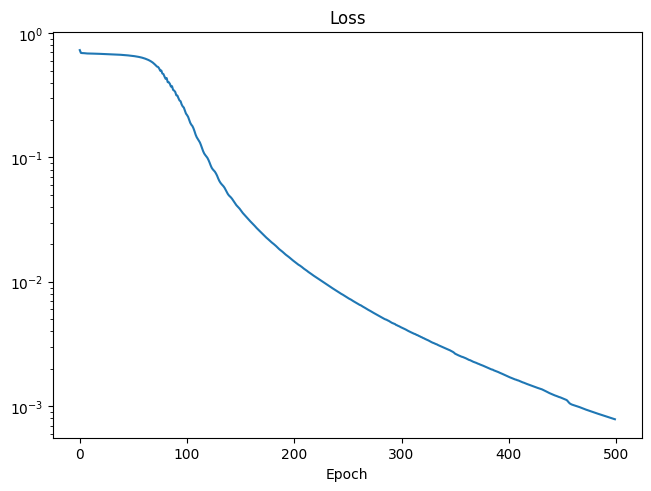

In [76]:
tf.config.run_functions_eagerly(False)
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=500, batch_size=train_X.shape[0], verbose=0, callbacks=[toolkit.LessVerboseProgressLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

In [18]:
model.loss

'binary_crossentropy'

In [19]:
model.metrics

[<Mean name=loss>]

## Custom training loop
First, we'll just check that we can run a custom training loop without any extra processing and confirm that it runs at about the same pace.

Surprisingly, it turns out that my custom training loop runs in about 25% of the time per epoch. The reference implementation contains lots of extra logic, so this must just be python at work when the overheads are multiplied by so many tiny epochs.

Execution mode: autograph
Epoch    50 - 40.69ms/epoch: loss: 0.5842  mse: 0.1970  
Epoch   100 - 8.07ms/epoch: loss: 0.1716  mse: 0.0362  
Epoch   150 - 7.47ms/epoch: loss: 0.0482  mse: 0.0074  
Epoch   200 - 7.74ms/epoch: loss: 0.0221  mse: 0.0027  
Epoch   250 - 7.51ms/epoch: loss: 0.0119  mse: 0.0012  
Epoch   300 - 7.45ms/epoch: loss: 0.0071  mse: 0.0006  
Epoch   350 - 6.95ms/epoch: loss: 0.0046  mse: 0.0003  
Epoch   400 - 7.58ms/epoch: loss: 0.0032  mse: 0.0002  
Epoch   450 - 7.37ms/epoch: loss: 0.0017  mse: 0.0001  
Epoch   500 - 7.36ms/epoch: loss: 0.0010  mse: 0.0000  
Total training time: 5.43 secs


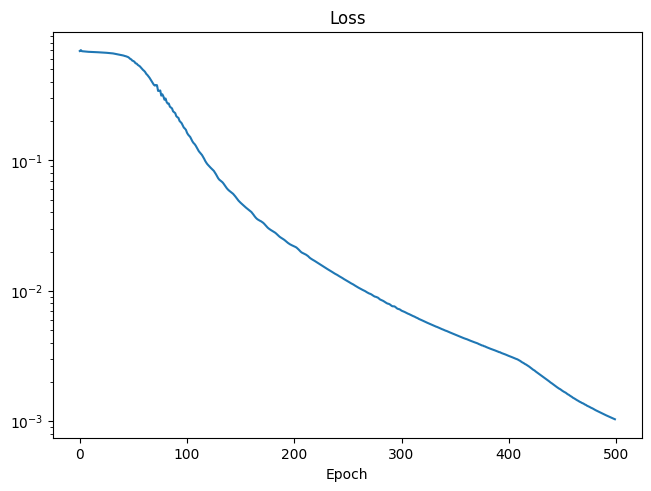

In [73]:
tf.config.run_functions_eagerly(False)
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(train_X.shape[0])
history = toolkit.fit(model, dataset, epochs=500, verbose=0, callbacks=[toolkit.LessVerboseProgressLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

## Capturing gradients
Now we build out the functionality to capture the gradients

In [119]:
model.trainable_variables

[<KerasVariable shape=(2, 100), dtype=float32, path=sequential_84/dense_504/kernel>,
 <KerasVariable shape=(100,), dtype=float32, path=sequential_84/dense_504/bias>,
 <KerasVariable shape=(100, 100), dtype=float32, path=sequential_84/dense_505/kernel>,
 <KerasVariable shape=(100,), dtype=float32, path=sequential_84/dense_505/bias>,
 <KerasVariable shape=(100, 100), dtype=float32, path=sequential_84/dense_506/kernel>,
 <KerasVariable shape=(100,), dtype=float32, path=sequential_84/dense_506/bias>,
 <KerasVariable shape=(100, 100), dtype=float32, path=sequential_84/dense_507/kernel>,
 <KerasVariable shape=(100,), dtype=float32, path=sequential_84/dense_507/bias>,
 <KerasVariable shape=(100, 5), dtype=float32, path=sequential_84/dense_508/kernel>,
 <KerasVariable shape=(5,), dtype=float32, path=sequential_84/dense_508/bias>,
 <KerasVariable shape=(5, 1), dtype=float32, path=sequential_84/dense_509/kernel>,
 <KerasVariable shape=(1,), dtype=float32, path=sequential_84/dense_509/bias>]

In [123]:
model.layers

[<Dense name=dense_504, built=True>,
 <Dense name=dense_505, built=True>,
 <Dense name=dense_506, built=True>,
 <Dense name=dense_507, built=True>,
 <Dense name=dense_508, built=True>,
 <Dense name=dense_509, built=True>]

In [124]:
model.layers[0].trainable_variables

[<KerasVariable shape=(2, 100), dtype=float32, path=sequential_84/dense_504/kernel>,
 <KerasVariable shape=(100,), dtype=float32, path=sequential_84/dense_504/bias>]

In [125]:
model.layers[0].trainable_variables[0] in model.trainable_variables

True

In [129]:
model.layers[3].trainable_variables[0]

<KerasVariable shape=(100, 100), dtype=float32, path=sequential_85/dense_513/kernel>

In [131]:
def index_by_identity(lst, target):
  return next((i for i, v in enumerate(lst) if id(v) == id(target)), -1)
#model.trainable_variables.index(model.layers[3].trainable_variables[0])
index_by_identity(model.trainable_variables, model.layers[3].trainable_variables[0])

6

In [90]:
def list_gradients(gradients_list):
  print(f"Gradients_list:")
  print(f"  list shape: {len(gradients_list)} x {len(gradients_list[0])} of {type(gradients_list[0][0])}")
  for l in range(len(gradients_list[0]) // 2):
    print(f"  layer {l:2}:  weights: {gradients_list[0][l*2].shape} of {gradients_list[0][l*2].dtype}, bias: {gradients_list[0][l*2+1].shape} of {gradients_list[0][l*2+1].dtype}")

  for e in range(len(gradients_list)):
    print(f"Step {e}:")
    for l in range(len(gradients_list[0]) // 2):
      w_mean = tf.reduce_mean(tf.abs(gradients_list[e][l*2]))
      w_min = tf.reduce_min(tf.abs(gradients_list[e][l*2]))
      w_max = tf.reduce_max(tf.abs(gradients_list[e][l*2]))
      w_std = tf.math.reduce_std(tf.abs(gradients_list[e][l*2]))
      b_mean = tf.reduce_mean(tf.abs(gradients_list[e][l*2+1]))
      b_min = tf.reduce_min(tf.abs(gradients_list[e][l*2+1]))
      b_max = tf.reduce_max(tf.abs(gradients_list[e][l*2+1]))
      b_std = tf.math.reduce_std(tf.abs(gradients_list[e][l*2+1]))
      print(f"  layer {l:2}:  weights: mean: {w_mean:.5f}, min: {w_min:.5f}, max: {w_max:.5f}, std: {w_std:.5f},  bias: mean: {b_mean:.5f}, min: {b_min:.5f}, max: {b_max:.5f}, std: {b_std:.5f}")
      #print(f"  layer {l:2}:  weights: mean: {mean:.5f}, min: {min:.5f}, max: {max:.5f}, std: {std:.5f}")

def list_stats(gradients_cb):
  print(f"Gradients callback summary:")
  if hasattr(gradients_cb,'epochs'):
    print(f"  Epochs: {len(gradients_cb.epochs)} ({gradients_cb.epochs[0]} .. {gradients_cb.epochs[-1]})")
  if hasattr(gradients_cb,'steps'):
    print(f"steps: {len(gradients_cb.steps)} ({gradients_cb.steps[0]} .. {gradients_cb.steps[-1]})")
  print(f"Model:")
  for key in gradients_cb.model_stats.keys():
    stats = gradients_cb.model_stats[key]
    print(f"  {key:4} ({len(stats)}): {stats[0:3]} .. {stats[-3:]}")
  for l in range(len(gradients_cb.layer_stats)):
    if gradients_cb.layer_stats[l] is not None:
      print(f"Layer {l}:")
      for key in gradients_cb.layer_stats[l].keys():
        stats = gradients_cb.layer_stats[l][key]
        print(f"  {key:4} ({len(stats)}): {stats[0:3]} .. {stats[-3:]}")


reload(toolkit)
tf.config.run_functions_eagerly(False)
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(train_X.shape[0])
#gradients = MyGradientCallback()
gradients = toolkit.GradientHistoryCallback()
history = toolkit.fit(model, dataset, epochs=100, verbose=0, callbacks=[toolkit.LessVerboseProgressLogger()], gradient_callback=gradients)
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

#list_gradients(gradients.gradients_list)
#list_stats(gradients)



Epoch    10 - 401.76ms/epoch: loss: 0.6839  mse: 0.2454  
Epoch    20 - 26.63ms/epoch: loss: 0.6650  mse: 0.2362  
Epoch    30 - 35.67ms/epoch: loss: 0.6233  mse: 0.2153  
Epoch    40 - 32.08ms/epoch: loss: 0.5564  mse: 0.1859  
Epoch    50 - 23.04ms/epoch: loss: 0.4744  mse: 0.1457  
Epoch    60 - 28.56ms/epoch: loss: 0.3673  mse: 0.1098  
Epoch    70 - 28.32ms/epoch: loss: 0.4146  mse: 0.1382  
Epoch    80 - 25.17ms/epoch: loss: 0.2010  mse: 0.0449  
Epoch    90 - 22.49ms/epoch: loss: 0.1408  mse: 0.0296  
Epoch   100 - 26.73ms/epoch: loss: 0.0762  mse: 0.0118  
Total training time: 6.62 secs


In [87]:
list_stats(gradients)

Gradients callback summary:
steps: 100 (0 .. 99)
Model:
  mean (100): [0.00367285 0.00101891 0.00028513] .. [0.00231402 0.00110633 0.00240517]
  min  (100): [0. 0. 0.] .. [0. 0. 0.]
  max  (100): [0.24757552 0.09648421 0.03483986] .. [0.14165917 0.1565561  0.1731509 ]
  std  (100): [0.0080237  0.0022758  0.00055331] .. [0.0044642  0.00236409 0.00464732]
Layer 0:
  mean (100): [0.00549422 0.00184539 0.00055616] .. [0.00565808 0.00452335 0.00913165]
  min  (100): [1.9572821e-05 8.2716069e-06 9.1292895e-07] .. [5.5442797e-08 4.1004969e-06 4.8709800e-05]
  max  (100): [0.03557263 0.01220508 0.0033393 ] .. [0.03786202 0.03003508 0.06348587]
  std  (100): [0.00566068 0.00212398 0.00051463] .. [0.00607922 0.00484617 0.01005871]
Layer 2:
  mean (100): [0.00293107 0.00082231 0.0003022 ] .. [0.00330858 0.00171297 0.00336977]
  min  (100): [0. 0. 0.] .. [0. 0. 0.]
  max  (100): [0.06235445 0.01525906 0.00451313] .. [0.06815107 0.04556902 0.06445088]
  std  (100): [0.00465764 0.00142882 0.00044895

grid: 5 x 4


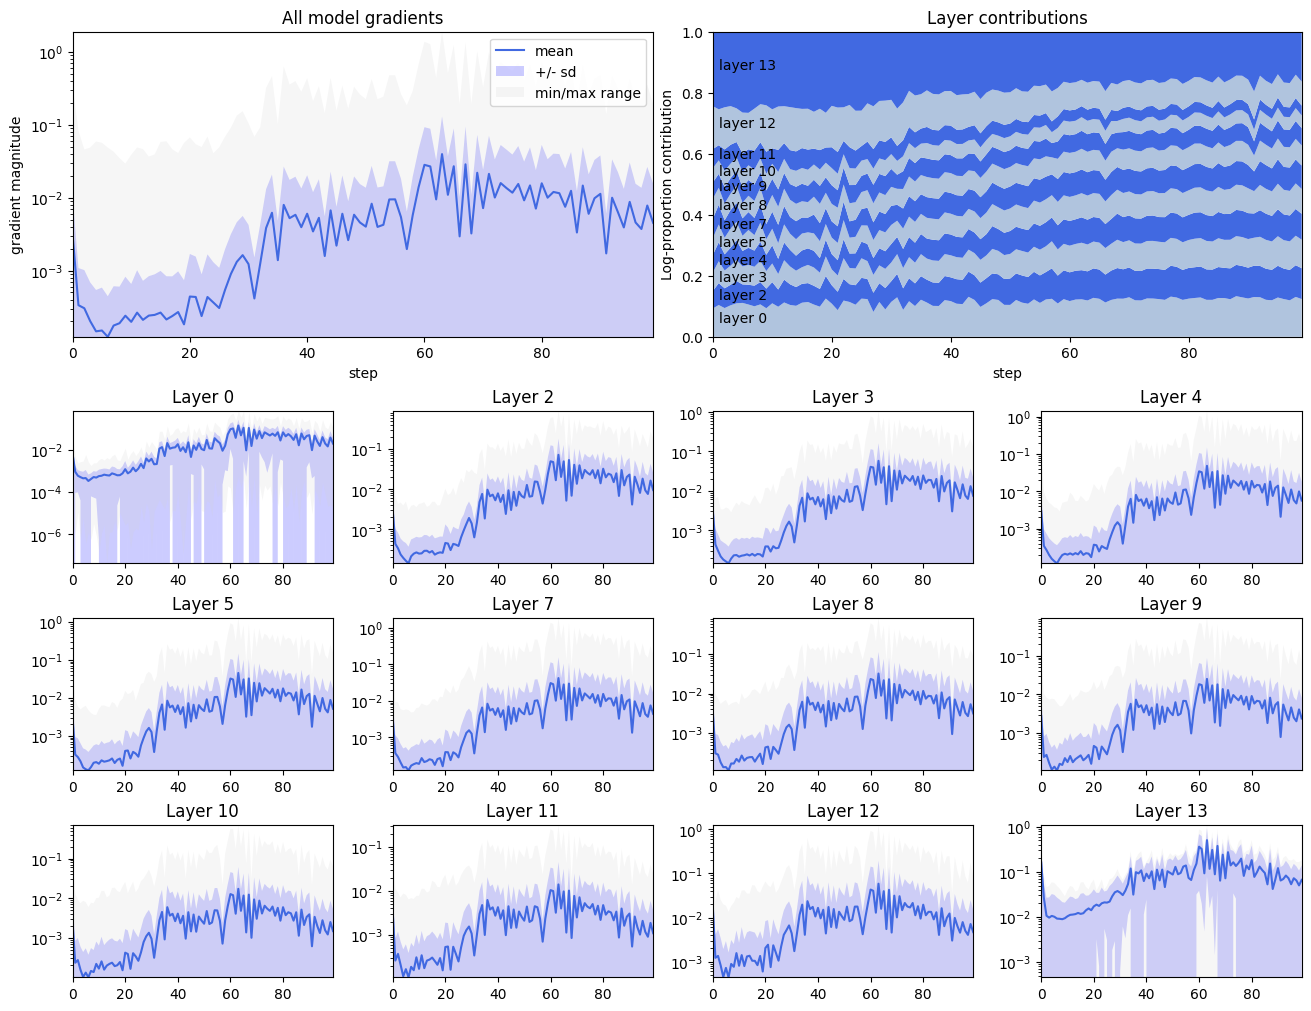

In [96]:
def show_gradient_stats(gradients_cb: toolkit.GradientHistoryCallback):
    """
    Generates a figure containing a number of plots to visualise gradient stats
    from a GradientHistoryCallback object.

    Args:
        gradients_cb: gradients collected during training.
    """
    steps = gradients_cb.steps

    # get filtered set of layer stats (dropping those with no stats)
    layer_ids = [idx for idx, stats in enumerate(gradients_cb.layer_stats) if stats is not None]
    layer_stats = [stats for stats in gradients_cb.layer_stats if stats is not None]
    num_layers = len(layer_stats)

    layer_log_means = np.column_stack([stats['mean'] for stats in layer_stats])
    layer_log_means = toolkit._log_normalize(layer_log_means, axis=1)

    # start figure
    grid_width = max(2, round(math.sqrt(num_layers) / 2) * 2)  # nearest even number >= 2
    grid_height = 2 + math.ceil(num_layers / grid_width)
    print(f"grid: {grid_height} x {grid_width}")
    plt.figure(figsize=(13, 4 * grid_height/2), layout='constrained')

    # all-model high-level summary
    plt.subplot2grid((grid_height, grid_width), (0, 0), colspan=grid_width // 2, rowspan=2)
    means = gradients_cb.model_stats['mean']
    stds = gradients_cb.model_stats['std']
    mins = gradients_cb.model_stats['min']
    maxs = gradients_cb.model_stats['max']
    plt.plot(steps, means, label='mean', color='royalblue')
    plt.fill_between(steps, means - stds, means + stds, color='blue', alpha=0.2, linewidth=0, label='+/- sd')
    plt.fill_between(steps, mins, maxs, color='lightgray', linewidth=0, alpha=0.2, label='min/max range')
    plt.margins(0)
    plt.yscale('log')
    plt.xlabel('step')
    plt.ylabel('gradient magnitude')
    plt.title('All model gradients')
    plt.legend()

    # layer contributions - high-level summary
    plt.subplot2grid((grid_height, grid_width), (0, grid_width // 2), colspan=grid_width // 2, rowspan=2)
    plt.stackplot(steps, layer_log_means.T, colors=['lightsteelblue', 'royalblue'], linewidth=0)
    plt.margins(0)
    plt.xlabel('step')
    plt.ylabel('Log-proportion contribution')
    plt.title('Layer contributions')
    # layer labels placed on centre of layer band on left-hand side
    placement = layer_log_means[0, :] * 0.5
    placement[1:] += np.cumsum(layer_log_means[0, :])[0:-1]
    for l_idx in range(layer_log_means.shape[1]):
        plt.text(len(steps) / 100, placement[l_idx], f"layer {layer_ids[l_idx]}", ha="left")

    # individual layers
    for l_idx in range(num_layers):
        r = 2 + l_idx // grid_width
        c = l_idx % grid_width
        plt.subplot2grid((grid_height, grid_width), (r, c))
        means = layer_stats[l_idx]['mean']
        stds = layer_stats[l_idx]['std']
        mins = layer_stats[l_idx]['min']
        maxs = layer_stats[l_idx]['max']
        plt.plot(steps, means, label='mean', color='royalblue')
        plt.fill_between(steps, means - stds, means + stds, color='blue', alpha=0.2, linewidth=0, label='+/- sd')
        plt.fill_between(steps, mins, maxs, color='lightgray', linewidth=0, alpha=0.2, label='min/max range')
        plt.margins(0)
        plt.yscale('log')
        plt.title(f"Layer {layer_ids[l_idx]}")

    plt.show()

show_gradient_stats(gradients)

In [95]:
num_layers=12
#min(2, round(math.sqrt(num_layers) / 2) * 2)
roundmath.sqrt(12) / 2

1.7320508075688772

In [70]:
def nearest_even(v: float):
  return round(v / 2) * 2

for v in [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]:
  print(f"{v} -> {nearest_even(v)}")

0 -> 0
0.5 -> 0
1.0 -> 0
1.5 -> 2
2.0 -> 2
2.5 -> 2
3.0 -> 4
3.5 -> 4


In [25]:
s = np.column_stack([gradients.layer_stats[l]['mean'] for l in range(len(gradients.layer_stats))])
s.shape

(1000, 6)

In [152]:
v = tf.Variable(tf.zeros((10,)), dtype=tf.float32)
v[2].assign(3.0)
v

<tf.Variable 'Variable:0' shape=(10,) dtype=float32, numpy=array([0., 0., 3., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [80]:
model.losses

[]

In [68]:
src = np.array([1e-3, 1e-1, 1e-2, 1e2])
log_scaled = np.log(src)
log_scaled = log_scaled - (np.min(log_scaled) - 1)  # move everything into positive, with lowest value having a relative unit scale of 1.0
log_scaled /= np.sum(log_scaled)

inverse_scaled = 1/src
inverse_scaled /= np.sum(inverse_scaled)

log_norm_softmax = np.log(src + 1)  # avoid log(0)
log_norm_softmax /= np.sum(log_norm_softmax)

print(f"src:              {src}")
print(f"log-scaled:       {lognorm(src)}")
print(f"log-scaled (ax0): {lognorm(src, axis=0)}")
print(f"------------")
print(f"log-scaled:       {log_scaled}")
print(f"softmax:          {tf.nn.softmax(src)}")
print(f"log:              {np.log(src)}")
print(f"inverse-scaled:   {inverse_scaled}")
print(f"log_norm_softmax: {log_norm_softmax}")

src:              [1.e-03 1.e-01 1.e-02 1.e+02]
log-scaled:       [0.04460168 0.25       0.14730084 0.55809748]
log-scaled (ax0): [0.04460168 0.25       0.14730084 0.55809748]
------------
log-scaled:       [0.04460168 0.25       0.14730084 0.55809748]
softmax:          [3.72379791e-44 4.11131978e-44 3.75746336e-44 1.00000000e+00]
log:              [-6.90775528 -2.30258509 -4.60517019  4.60517019]
inverse-scaled:   [9.00892785e-01 9.00892785e-03 9.00892785e-02 9.00892785e-06]
log_norm_softmax: [2.11696627e-04 2.01869303e-02 2.10750453e-03 9.77493869e-01]


In [60]:
a = np.array([[1, 2, 3], [4, 5, 6]])
a / np.sum(a, axis=1, keepdims=True)

array([[0.16666667, 0.33333333, 0.5       ],
       [0.26666667, 0.33333333, 0.4       ]])

## Appendix: Prove out maths behind implementation of Welford's algorithm

In [118]:
def _compute_stats_numpy(gradients):
  mags = [tf.abs(g).numpy() for g in gradients]
  mags = np.stack(mags)
  print(f"numpy, mags: {mags.shape}")
  return {
      'mean': np.mean(mags),
      'min': np.min(mags),
      'max': np.max(mags),
      'std': np.std(mags)
  }

def _compute_stats_brute(gradients):
  mags = [tf.abs(g) for g in gradients]
  mags = tf.stack(mags)
  return {
      'mean': tf.reduce_mean(mags).numpy(),
      'min': tf.reduce_min(mags).numpy(),
      'max': tf.reduce_max(mags).numpy(),
      'std': tf.math.reduce_std(mags).numpy()
  }

def _compute_stats(gradients):
  n = tf.constant(0.0, dtype=tf.float32)
  mean = tf.constant(0.0, dtype=tf.float32)
  M2 = tf.constant(0.0, dtype=tf.float32)  # Sum of squared differencse from the mean
  min = None
  max = None

  # TODO: sanity check this against brute-force approach
  for g in gradients:
    g_mags = tf.abs(g)
    g_size = tf.size(g, out_type=tf.float32)
    g_min = tf.reduce_min(g_mags)
    g_max = tf.reduce_max(g_mags)
    g_sum = tf.reduce_sum(g_mags)
    g_mean = g_sum / g_size
    g_var = tf.reduce_sum((g_mags - g_mean)**2)

    if min == None or g_min < min:
      min = g_min
    if max == None or g_max > max:
      max = g_max

    # Welford's algorithm for computing running statistics
    delta = g_mean - mean
    n += g_size
    mean += delta * (g_size / n)
    M2 += g_var + delta**2 * (g_size * (n - g_size) / n)

  if n > 1:
    return {
        'mean': mean.numpy(),
        'min': min.numpy(),
        'max': max.numpy(),
        'std': tf.sqrt(M2 / n).numpy()
    }
  else:
    return {
        'mean': 0.0,
        'min': 0.0,
        'max': 0.0,
        'std': 0.0
    }


gradients = [
    tf.constant([0.1, 0.2, 0.3]),
    tf.constant([0.4, 0.5, 0.6]),
    tf.constant([0.7, 0.8, 0.9]),
]

print(f"numpy:     {_compute_stats_numpy(gradients)}")
print(f"brute:     {_compute_stats_brute(gradients)}")
print(f"efficient: {_compute_stats(gradients)}")

numpy, mags: (3, 3)
numpy:     {'mean': 0.5, 'min': 0.1, 'max': 0.9, 'std': 0.2581989}
brute:     {'mean': 0.5, 'min': 0.1, 'max': 0.9, 'std': 0.2581989}
efficient: {'mean': 0.5, 'min': 0.1, 'max': 0.9, 'std': 0.2581989}
